# Machine Learning with Graph Features
## Notebook 2

In this notebook, we will train to ML models to peform selling price predictions. The first will use traditional, one-hot encoded features, while the second will incorporated graph-derived features.

## Connect to TigerGraph Database

The code block below connects to a TigerGraph database. Make sure to change the authentication details in order for you to connect to the instance successfully.

In [1]:
from pyTigerGraph import TigerGraphConnection

conn=TigerGraphConnection(
    host="YOUR_HOSTNAME_HERE",
    graphname="KDD_2022_NFT",
    gsqlSecret="YOUR_SECRET_HERE"
)
conn.getToken("YOUR_SECRET_HERE")

('1q68tajcn5ps5psb7m8pnomgmq7en3tc', 1662843607, '2022-09-10 21:00:07')

## Activate Machine Learning Workbench Data Loaders
In order to use Kafka for data loading, we need to activate the functionality on the database. To do this, replace `YOUR_HOSTNAME_HERE` and `YOUR_SECRET_HERE` with your credentials below.

In [49]:
!mlwb activate YOUR_HOST_HERE -s YOUR_SECRET_HERE

Activating ML workbench for TigerGraph database at https://f8811d7fc06d4334bf6bc04903479b86.i.tgcloud.io:443
Activation finished successfully!


In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

conn.gds.configureKafka(kafka_address="kaf.kdd.tigergraphlabs.com:19092")

## Split the Data

We are going to use the built-in data splitter to split the data between training and testing data sets.

In [4]:
splitter = conn.gds.vertexSplitter(v_types=["Transaction"], train=0.8, test=0.2)

In [5]:
splitter.run()

Splitting vertices...
Vertex split finished successfully.


## Traditional Feature Approach

Here, we are going to train a neural network to perform regression of the selling price of the NFT, given the category and collection one-hot encoded vectors.

In [6]:
train_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["usd_price", "categoryOneHot", "collectionOneHot"]},
    filter_by="train",
    batch_size=2048,
    shuffle=True
)

In [7]:
import torch

nn = torch.nn.Sequential(
    torch.nn.Linear(1075, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

from torch.optim import Adam

opt = Adam(nn.parameters(), lr=0.01)
loss = torch.nn.SmoothL1Loss()
mae = torch.nn.L1Loss()

In [8]:
import numpy as np
def clean_onehots(x, length):
    arr = np.fromstring(x, sep=" ", dtype=np.float32)
    if len(arr) > length:
        arr = arr[:length]
    elif len(arr) < length:
        arr = np.zeros(length)
    return arr

In [9]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
# default `log_dir` is "runs" - we'll be more specific here

writer = SummaryWriter('runs/no_graph_feats_training'+str(datetime.now()))

### Training Loop

In [10]:
for i in range(10):
    epoch_loss = 0
    epoch_mae = 0
    j = 0
    for batch in train_loader:
        catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
        collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
        X = torch.tensor(np.concatenate([catOH, collOH], axis=1))
        y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
        out = nn(X).flatten()
        loss_val = loss(out, y)
        opt.zero_grad()
        loss_val.backward()
        opt.step()
        mae_val = mae(out, y).item()
        epoch_loss += loss_val.item()
        epoch_mae += mae_val

        
        writer.add_scalar('training loss',
                        loss_val.item(),
                        i * train_loader.num_batches + j)
        writer.add_scalar('training mae',
                          mae_val,
                          i * train_loader.num_batches + j)

        j += 1
    print("Epoch:", i, "Loss:", epoch_loss/train_loader.num_batches, "MAE:", epoch_mae/train_loader.num_batches)

Epoch: 0 Loss: 131.49427556991577 MAE: 131.9210670789083
Epoch: 1 Loss: 125.02977021535237 MAE: 125.43910757700603
Epoch: 2 Loss: 122.39192787806194 MAE: 122.81237808863322
Epoch: 3 Loss: 117.77112929026286 MAE: 118.18795204162598
Epoch: 4 Loss: 117.02807855606079 MAE: 117.44361702601115
Epoch: 5 Loss: 117.3426178296407 MAE: 117.75987323125203
Epoch: 6 Loss: 115.72211758295695 MAE: 116.14114268620808
Epoch: 7 Loss: 116.07165845235188 MAE: 116.48535060882568
Epoch: 8 Loss: 119.53386147816975 MAE: 119.94937419891357
Epoch: 9 Loss: 117.06103420257568 MAE: 117.47730366388957


### Setup TensorBoard

Once we setup our TensorBoard Writer in the cell above, we can create the TensorBoard visualization in TigerGraph ML Workbench.

In [11]:
import os

notebook_pvc = '-'.join(os.environ['HOSTNAME'].split('-')[:-1] + ['volume'])

log_dir = "kdd2022-tutorial/notebooks/runs"

def kubectl_cmd(yaml, action, *arg):
    return f"cat <<EOF | kubectl {action} -f -" + yaml.format(*arg) + "EOF"


yaml_tb = """
apiVersion: tensorboard.kubeflow.org/v1alpha1
kind: Tensorboard
metadata:
  name: my-tensorboard
spec:
  logspath: pvc://{0}/{1}
"""

cmd = kubectl_cmd(yaml_tb, 'apply', notebook_pvc, log_dir)
print(cmd)

cat <<EOF | kubectl apply -f -
apiVersion: tensorboard.kubeflow.org/v1alpha1
kind: Tensorboard
metadata:
  name: my-tensorboard
spec:
  logspath: pvc://kdd-5-volume/kdd2022-tutorial/notebooks/runs
EOF


In [12]:
!$cmd

tensorboard.tensorboard.kubeflow.org/my-tensorboard unchanged


Once we run this command, you can navigate back to the ML Workbench homepage. Click on **Tensorboards** on the left hand menu bar. This should take you to a screen like this:

<img src="../img/tensorBoardTab.png" alt="drawing" width="800"/>

On the row that corresponds to **my-tensorboard**, click **Connect**. This will bring you to your Tensorboard page where you can monitor the training progress of your models.

### Test the Model

In [13]:
test_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["usd_price", "categoryOneHot", "collectionOneHot"]},
    filter_by="test",
    batch_size=2048
)

In [14]:
mae_sum = 0
for batch in test_loader:
    catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
    collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
    X = torch.tensor(np.concatenate([catOH, collOH], axis=1))
    y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
    with torch.no_grad():
        out = nn(X).flatten()
        mae_sum += mae(out, y).item()
print("MAE:", mae_sum/test_loader.num_batches,)

MAE: 76.05050404866536


## Add Graph Features

**HANDS ON CODE:** Check `query_answers` directory if you are not participating in the live tutorial.

We want to enrich the model with graph-based features. Lets create some features that incorporate community and centrality information.

In [15]:
%%writefile ./seller_pagerank.gsql


CREATE QUERY seller_pagerank(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @seller_pr;
    MaxAccum<DOUBLE> @@max_seller_pr;


    res = SELECT t FROM transactions:t -(NFT_SOLD_BY)-> NFT_User:u 
          ACCUM
            t.@seller_pr += u.pagerank,
            @@max_seller_pr += u.pagerank
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@seller_pr/@@max_seller_pr)
            END;
    IF print_accum THEN
      PRINT res[res.@seller_pr];
    END;
}

Overwriting ./seller_pagerank.gsql


In [16]:
featurizer = conn.gds.featurizer()

In [17]:
featurizer.installAlgorithm("seller_pagerank", query_path="./seller_pagerank.gsql")

'seller_pagerank'

In [18]:
params = {"result_attr": "seller_pr"}

featurizer.runAlgorithm("seller_pagerank", params, feat_name="seller_pr", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])

[]

In [19]:
%%writefile ./buyer_pagerank.gsql


CREATE QUERY buyer_pagerank(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @buyer_pr;
    MaxAccum<DOUBLE> @@max_buyer_pr;


    res = SELECT t FROM transactions:t -(NFT_BOUGHT_BY)-> NFT_User:u 
          ACCUM
            t.@buyer_pr += u.pagerank,
            @@max_buyer_pr += u.pagerank
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@buyer_pr/@@max_buyer_pr)
            END;
    IF print_accum THEN
      PRINT res[res.@buyer_pr];
    END;
}

Overwriting ./buyer_pagerank.gsql


In [20]:
featurizer.installAlgorithm("buyer_pagerank", query_path="./buyer_pagerank.gsql")

'buyer_pagerank'

In [21]:
params = {"result_attr": "buyer_pr"}

featurizer.runAlgorithm("buyer_pagerank", params, feat_name="buyer_pr", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])

[]

In [22]:
%%writefile ./kcore_size.gsql


CREATE QUERY kcore_size(BOOL print_accum = FALSE, STRING result_attr = "") FOR GRAPH KDD_2022_NFT { 
  MapAccum<INT, SumAccum<FLOAT>> @@kcore_size;
  MaxAccum<FLOAT> @@max_kcore_size;

  
  nftuser = {NFT_User.*};
  
  res = SELECT t FROM nftuser:t POST-ACCUM @@kcore_size += (t.k_core -> 1);
  
  IF print_accum THEN
    PRINT @@kcore_size;
  END;

  FOREACH (key, value) IN @@kcore_size DO
    @@max_kcore_size += value;
  END;
  
  IF result_attr != "" THEN
    res = SELECT t FROM nftuser:t POST-ACCUM t.setAttr(result_attr, @@kcore_size.get(t.k_core)/@@max_kcore_size);
  END;
}

Overwriting ./kcore_size.gsql


In [23]:
featurizer.installAlgorithm("kcore_size", query_path="./kcore_size.gsql")

'kcore_size'

In [24]:
params = {"result_attr": "kcore_size"}

featurizer.runAlgorithm("kcore_size", params, feat_name="kcore_size", feat_type="DOUBLE", custom_query=True, schema_name=["NFT_User"])

[]

In [25]:
%%writefile ./seller_kcore_size.gsql


CREATE QUERY seller_kcore_size(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @seller_k_size;


    res = SELECT t FROM transactions:t -(NFT_SOLD_BY)-> NFT_User:u 
          ACCUM
            t.@seller_k_size += u.kcore_size
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@seller_k_size)
            END;
    IF print_accum THEN
      PRINT res[res.@seller_k_size];
    END;
}

Overwriting ./seller_kcore_size.gsql


In [26]:
featurizer.installAlgorithm("seller_kcore_size", query_path="./seller_kcore_size.gsql")

'seller_kcore_size'

In [27]:
params = {"result_attr": "seller_k_size"}

featurizer.runAlgorithm("seller_kcore_size", params, feat_name="seller_k_size", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])

[]

In [28]:
%%writefile ./buyer_kcore_size.gsql


CREATE QUERY buyer_kcore_size(BOOL print_accum = FALSE, STRING result_attr = "") {
    transactions = {Transaction.*};
    SumAccum<DOUBLE> @buyer_k_size;


    res = SELECT t FROM transactions:t -(NFT_BOUGHT_BY)-> NFT_User:u 
          ACCUM
            t.@buyer_k_size += u.kcore_size
          POST-ACCUM
            IF result_attr != "" THEN
                t.setAttr(result_attr, t.@buyer_k_size)
            END;
    IF print_accum THEN
      PRINT res[res.@buyer_k_size];
    END;
}

Overwriting ./buyer_kcore_size.gsql


In [29]:
featurizer.installAlgorithm("buyer_kcore_size", query_path="./buyer_kcore_size.gsql")

'buyer_kcore_size'

In [30]:
params = {"result_attr": "buyer_k_size"}

featurizer.runAlgorithm("buyer_kcore_size", params, feat_name="buyer_k_size", feat_type="DOUBLE", custom_query=True, schema_name=["Transaction"])

[]

## Train Neural Network with Graph-Based Features

Using the same size (apart from the input dimension) of neural network, lets train and evaluate a model using both traditional and graph-based features.

In [31]:
train_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["buyer_k_size", "seller_k_size", "usd_price", "seller_pr", "buyer_pr", "categoryOneHot", "collectionOneHot"]},
    filter_by="train",
    batch_size=2048,
    shuffle=True
)

In [32]:
import torch

nn = torch.nn.Sequential(
    torch.nn.Linear(1079, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 1000),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 1)
)

from torch.optim import Adam

opt = Adam(nn.parameters(), lr=0.01)
loss = torch.nn.SmoothL1Loss()
mae = torch.nn.L1Loss()

In [33]:
writer = SummaryWriter('runs/graph_feats_training'+str(datetime.now()))

In [34]:
for i in range(10):
    epoch_loss = 0
    epoch_mae = 0
    j = 0
    for batch in train_loader:
        catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
        collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
        X = torch.tensor(np.concatenate([batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
        y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
        out = nn(X).flatten()
        loss_val = loss(out, y)
        opt.zero_grad()
        loss_val.backward()
        opt.step()
        mae_val = mae(out, y).item()
        epoch_loss += loss_val.item()
        epoch_mae += mae_val
        writer.add_scalar('training loss',
                        loss_val.item(),
                        i * train_loader.num_batches + j)
        writer.add_scalar('training mae',
                          mae_val,
                          i * train_loader.num_batches + j)
        j += 1
    print("Epoch:", i, "Loss:", epoch_loss/train_loader.num_batches, "MAE:", epoch_mae/train_loader.num_batches)

Epoch: 0 Loss: 131.71093050638834 MAE: 132.13320318857828
Epoch: 1 Loss: 125.27488565444946 MAE: 125.69008032480876
Epoch: 2 Loss: 122.85316133499146 MAE: 123.26313638687134
Epoch: 3 Loss: 121.29591449101765 MAE: 121.71177403132121
Epoch: 4 Loss: 116.97806406021118 MAE: 117.38390445709229
Epoch: 5 Loss: 117.09480905532837 MAE: 117.5118187268575
Epoch: 6 Loss: 116.32744201024373 MAE: 116.75218375523885
Epoch: 7 Loss: 116.05705897013347 MAE: 116.47004731496175
Epoch: 8 Loss: 115.87256304423015 MAE: 116.28762642542522
Epoch: 9 Loss: 120.000563621521 MAE: 120.40958944956462


In [35]:
test_loader = conn.gds.vertexLoader(
    attributes={"Transaction": ["seller_k_size", "buyer_k_size", "usd_price", "seller_pr", "buyer_pr", "categoryOneHot", "collectionOneHot"]},
    filter_by="test",
    batch_size=2048
)

In [36]:
mae_sum = 0
for batch in test_loader:
    catOH = torch.tensor(np.stack(batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
    collOH = torch.tensor(np.stack(batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
    X = torch.tensor(np.concatenate([batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
    y = torch.tensor(batch["Transaction"]["usd_price"].values.astype(np.float32))
    with torch.no_grad():
        out = nn(X).flatten()
        mae_sum += mae(out, y).item()
print("MAE:", mae_sum/test_loader.num_batches)

MAE: 72.72719383239746


## Determine Graph Feature Importance

Using **Captum**, we can determine the attribution scores of each graph-based feature to the model.

In [37]:
from captum.attr import GradientShap

gs = GradientShap(nn)

In [38]:
# This cell takes a little while to run

train_X = []


for train_batch in train_loader:
    catOH = torch.tensor(np.stack(train_batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
    collOH = torch.tensor(np.stack(train_batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
    train_x = torch.tensor(np.concatenate([train_batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
    train_X.append(train_x)
train_X = torch.concat(train_X)

test_X = []
for test_batch in test_loader:
    catOH = torch.tensor(np.stack(test_batch["Transaction"]["categoryOneHot"].apply(lambda x: clean_onehots(x, 6)).values).astype(np.float32))
    collOH = torch.tensor(np.stack(test_batch["Transaction"]["collectionOneHot"].apply(lambda x: clean_onehots(x, 1069)).values).astype(np.float32))
    test_x = torch.tensor(np.concatenate([test_batch["Transaction"][["seller_k_size", "buyer_k_size", "seller_pr", "buyer_pr"]].values.astype(np.float32), catOH, collOH], axis=1))
    test_X.append(test_x)
test_X = torch.concat(test_X)

In [39]:
train_X.shape

torch.Size([47595, 1079])

In [40]:
test_X.shape

torch.Size([11739, 1079])

In [41]:
attribution = gs.attribute(test_X, train_X)

[Text(0, 0, 'Seller_k_size'),
 Text(1, 0, 'Buyer_k_size'),
 Text(2, 0, 'Seller_pr'),
 Text(3, 0, 'Buyer_pr')]

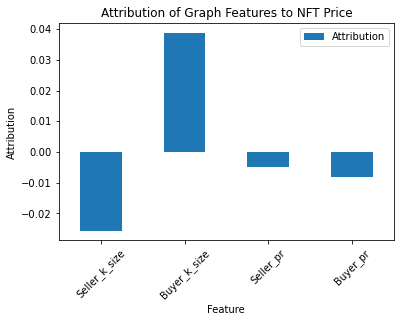

In [42]:
ig_nt_attr_test_sum = attribution.detach().numpy().sum(0)
ig_nt_attr_test_norm_sum = ig_nt_attr_test_sum / np.linalg.norm(ig_nt_attr_test_sum, ord=1)

attributions = pd.DataFrame({"Feature": ["Seller_k_size", "Buyer_k_size", "Seller_pr", "Buyer_pr"], "Attribution": ig_nt_attr_test_norm_sum[:4]})

plt = attributions.plot(kind="bar", xlabel="Feature", ylabel="Attribution", title="Attribution of Graph Features to NFT Price")
plt.set_xticklabels(attributions.Feature, rotation=45)